# Document selection

In [1]:
%matplotlib inline
import pickle
from os import listdir, makedirs
from os.path import join, isfile, exists, dirname
import gc
import re
import math
from itertools import islice
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
%pylab inline
import numpy as np
import pandas as pd
from tqdm._tqdm_notebook import tqdm_notebook

from constants import *
from utils import load, init_logging, tprint, TopicsLoader
from topic_reranking import Reranker

tqdm_notebook.pandas()
pd.options.display.max_columns = 80
pd.options.display.max_rows = 200
pd.options.display.precision = 3

Populating the interactive namespace from numpy and matplotlib


In [22]:
FACTOR = 0.001 # the factor is arbitrary and empirically chosen

def make_footprint(documents, factor=FACTOR):
    char_freq = defaultdict(int)
    train_len = 0
    for string in documents:
        train_len += len(string)
        for char in string.lower():
            char_freq[char] += 1
    for k in char_freq.keys():
        char_freq[k] //= (train_len * factor)
    return char_freq

def character_distance(string, footprint, factor=FACTOR):
    distance = 0
    doc_freq = defaultdict(int)
    doc_len = len(string)//2
    if doc_len == 0:
        return 1 / factor
    string = string[doc_len:]
    for char in string.lower():
        doc_freq[char] += 1
    for k in doc_freq.keys():
        doc_freq[k] //= (doc_len * factor)
        distance += abs(doc_freq[k] - footprint.get(k, 0))
    return int(distance)

def chardist_plot(df, name, save=True, threshold=None, ylim=None):
    median = df.char_dist.median()
    mean = df.char_dist.mean()
    print('double median:', median * 2, '|', 'double mean:', mean * 2)
    if threshold is None:
        threshold = median + mean
        
    df['discarded'] = False
    df.discarded[df.char_dist > threshold] = True
    df['idx'] = list(range(len(df)))

    LABEL_SIZE = 15
    sns.set(color_codes=True, font_scale=1.2)
    sns.set_style("whitegrid", {'legend.frameon': True})

    lm = sns.lmplot(
        data=df, x='idx', y='char_dist', hue='discarded', fit_reg=False, height=7, aspect=2, scatter_kws={'s':2}, legend=False
    )
    ax = lm.axes[0, 0]
    if ylim is not None:
        ax.set_ylim((0, min(ax.get_ylim()[1], ylim)))
    ax.axhline(median * 2, ls=':', color='green', label="double median")
    ax.axhline(mean * 2, ls=':', color='red', label="double mean")
    ax.axhline(threshold, ls='-', color='orange', lw=1.5, label='threshold')
    ax.set_xlabel('documents', weight='bold', size=LABEL_SIZE)
    ax.set_ylabel('character distance', weight='bold', size=LABEL_SIZE)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        (handles[1], handles[2], handles[0], handles[-1]), 
        (labels[1], labels[2], labels[0], 'outlier'), 
        loc=4, markerscale=4., fontsize=15)
    ax.set_title(name, fontweight='bold', fontsize=LABEL_SIZE*1.1, x=.01, y=.99, ha='left', va='top')
    if save:
        lm.savefig(f'../img/{name.lower()}_chardist.pdf', bbox_inches='tight')
    df.drop(['discarded', 'idx'], axis=1)

### FAZ

In [5]:
df = load('FA', 'deprecated')

# SELECT TRAIN SET

df['str_len'] = df[TEXT].str.len()
# for the news datasets we regard only the second half of an article when the paywall sets in
half = df.apply(lambda x: x[TEXT][x['str_len']//2:], axis=1)
print(half.head(30))

# the first 25 articles are ok
train_ids = df.index[:25].tolist()
trainset = df.loc[train_ids, TEXT].tolist()

Reading ['../data/preprocessed/deprecated/FAZ.pickle.gz', '../data/preprocessed/deprecated/FAZ2.pickle.gz']
hash
 8270426679533743502    lsteuer auf die Gewinne amerikanischer Interne...
 1496606811913603616    hr ausreichend um Haus und Gärten kümmern könn...
-3182778197785981365    verkaufte Fahrzeuge zu erreichen und sie wahrs...
 5675331573923339973    rgangenen Jahren deutlich verbessert. Im Jahr ...
 2662614887127886036     gegen ein einzelnes Land gerichtet. Aber dahi...
 1251842103837422350    rung des Kraftstoffverbrauchs sowie der Betrie...
-5276645570622258046    i nicht beeinträchtigt.\nDer Aktienkurs des Au...
 2552812214857701279    en will. Es geht um mehr als das hohe Gut fina...
 3165142868638271389     gebracht – und die Diskussion um die Spiele-B...
-8559376481143991809     einen Islam gibt, und dass sich dieser im Kri...
 1958363566472439073    es vor fast vierzig Jahren den Begriff des „Ve...
-226021091439415694     ch, daß ein weiterer Grund für die Kriegserklä...

defaultdict(<class 'int'>, {'a': 52.0, 'u': 30.0, 'ß': 1.0, 'e': 134.0, 'n': 82.0, 'm': 24.0, 'i': 67.0, 's': 55.0, 't': 54.0, 'r': 63.0, ' ': 136.0, 'h': 36.0, 'k': 10.0, 'o': 22.0, 'c': 23.0, 'p': 8.0, '-': 1.0, 'g': 25.0, 'd': 38.0, 'b': 14.0, 'z': 9.0, '.': 8.0, 'f': 13.0, 'ü': 5.0, '„': 1.0, 'l': 29.0, '“': 1.0, 'ä': 5.0, 'v': 7.0, ',': 7.0, 'w': 12.0, '\n': 1.0, 'y': 1.0, 'ö': 1.0, 'j': 1.0, 'x': 0.0, '4': 0.0, '0': 1.0, '1': 0.0, '8': 0.0, '5': 0.0, '9': 0.0, '3': 0.0, 'q': 0.0, '–': 0.0, '2': 0.0, '6': 0.0, '7': 0.0, '(': 0.0, ')': 0.0, ':': 0.0, ';': 0.0, '?': 0.0, '\xa0': 0.0, '!': 0.0, 'ó': 0.0, '+': 0.0, '"': 0.0, 'é': 0.0, 'ç': 0.0})
example distances: [115, 92, 162, 115, 144, 144, 615, 101, 81, 165, 167, 157, 133, 162, 149, 223, 87, 104, 606, 641]
example for problematic document with distance: 631
Sind in der DDR Kinder fälschlicherweise für tot erklärt worden, um sie an verdiente Genossen weiterzugeben? Erst am Montag wurde auf Betreiben des Vereins „Interessengemeinsch

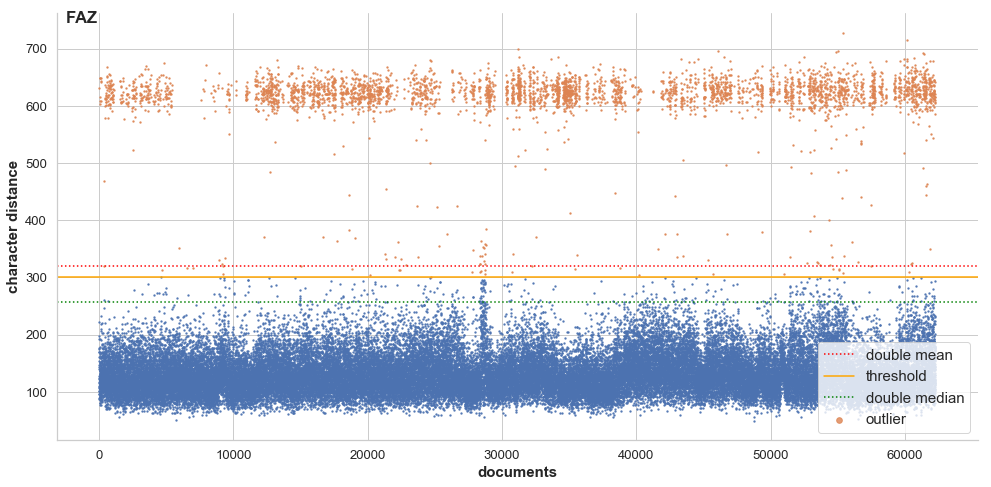

In [6]:
# GENERATE FOOTPRINT
footprint = footprint_faz = make_footprint(trainset)
print(footprint)
# compare scores for non-encrypted and encrypted articles
good = df.iloc[-20:][TEXT].tolist()
print('example distances:', [character_distance(string, footprint) for string in good])
bad = df.loc[5598736571409986456, TEXT]
print('example for problematic document with distance:', character_distance(bad, footprint))
print(bad)

# apply metric on corpus
df['char_dist'] = df[TEXT].apply(character_distance, footprint=footprint)

# plot data
threshold = 300
chardist_plot(df, 'FAZ', threshold=threshold)
# 300 seems to be a valid limit. We don't loose too many good articles here
outlier1 = df.loc[df.char_dist.between(300, 350), TEXT].tolist()
outlier2 = df.loc[df.char_dist.between(350, 550), TEXT].tolist()
print(len(outlier1), len(outlier2))
df_new = df[df.char_dist <= threshold]
print(len(df), len(df_new))
df_new = df_new.drop(['char_dist', 'str_len'], axis=1)
#df_new.to_pickle(join(ETL_PATH, 'FAZ.pickle'))

### FOCUS

In [7]:
df = load('FO', 'deprecated')

# SELECT TRAIN SET

df['str_len'] = df[TEXT].str.len()
# for the news datasets we regard only the second half of an article when the paywall sets in
half = df.apply(lambda x: x[TEXT][x['str_len']//2:], axis=1)
print(half.head(30))

# the first 25 articles are ok
train_ids = df.index[:25].tolist()
trainset = df.loc[train_ids, TEXT].tolist()

Reading ../data/preprocessed/deprecated/FOCUS.pickle.gz
hash
-6271408166694537994    ekauft hat, der muss die Kröte wohl oder übel ...
-7605027681485747078    en dem alten und dem neuen Modell das günstige...
 8295392811760430332    buchkulisse aus dem Katalog ließ sich auf dem ...
-4612670798912085660    ode-Share-Flüge sind heute so selbstverständli...
 4362080969320069233    agt Isabel. Das war vor vier Jahren. Abends na...
 2151887591378696601    ist. So wird der Kunde zwar direkt zur Kasse g...
-3273469669028248336    st. Beispiel Strandfarben: Die Palette reicht ...
-1218625107520702511    „Das Kranzbach“. Das denkmalgeschützte, hunder...
 2973943744481446760    -Einstellung deaktiviert. Noch sinnvoller wäre...
 6925517803186120879    ork statt. Passend dazu postete US-Schauspiele...
 5481889888718055100    ern. Mit einem Wattestäbchen voll Spiritus kön...
-2863998166816750793    recher mit einem falsch konfigurierten Netzwer...
-2417761083105946167    Störung war zunächst nicht 

defaultdict(<class 'int'>, {'b': 17.0, 'e': 134.0, 'i': 64.0, 'm': 20.0, ' ': 137.0, 'h': 35.0, 'z': 10.0, 'ö': 2.0, 'l': 33.0, '-': 4.0, 'k': 13.0, 'a': 47.0, 'u': 31.0, 'f': 13.0, 's': 53.0, 't': 52.0, 'd': 39.0, 'r': 58.0, 'c': 24.0, 'g': 22.0, 'n': 81.0, 'o': 26.0, '.': 9.0, 'w': 10.0, 'ü': 5.0, 'v': 7.0, ':': 1.0, ',': 6.0, 'p': 11.0, 'ä': 4.0, '8': 0.0, '1': 1.0, '2': 1.0, '0': 1.0, 'j': 1.0, '–': 0.0, 'ß': 1.0, '9': 0.0, '\n': 3.0, 'y': 1.0, '6': 0.0, '5': 0.0, '„': 0.0, '“': 0.0, '?': 0.0, '’': 0.0, '7': 0.0, 'x': 0.0, '(': 0.0, ')': 0.0, '*': 0.0, '3': 0.0, '4': 0.0, 'q': 0.0, '&': 0.0, ';': 0.0, '"': 0.0, '!': 0.0, '@': 0.0, '/': 0.0, "'": 0.0, '+': 0.0, 'é': 0.0})
example distances: [213, 172, 158, 238, 196, 181, 185, 116, 278, 96, 233, 195, 109, 148, 179, 174, 185, 225, 174, 153]
example for problematic document with distance: 622
1 Oceans Twelve (1)2. W.Regie: Steven Soderbergh, mit Brad Pitt, George Clooney, Julia Roberts. Besucher*: 294068/Gesamt: 1151023
double median: 

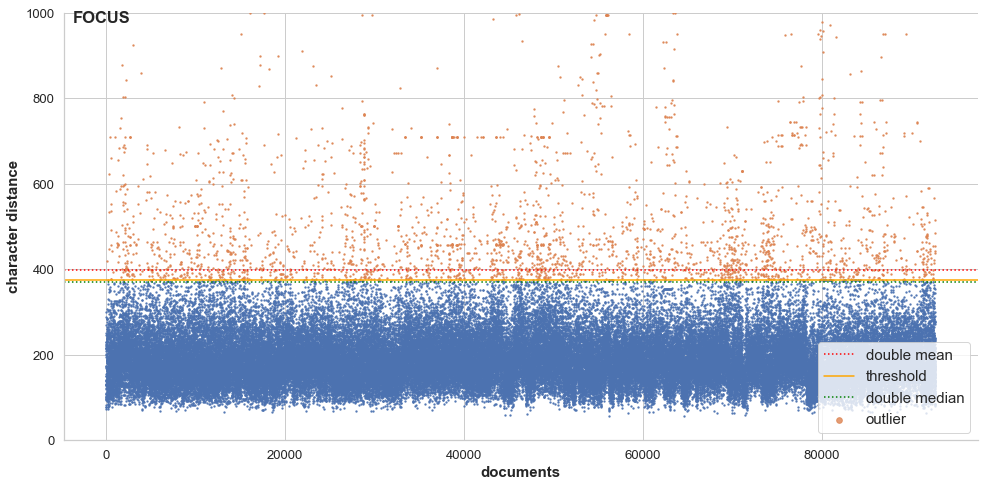

In [19]:
# GENERATE FOOTPRINT
footprint = footprint_focus = make_footprint(trainset)
print(footprint)
# compare scores for non-encrypted and encrypted articles
good = df.iloc[-20:][TEXT].tolist()
print('example distances:', [character_distance(string, footprint) for string in good])
bad = df.loc[7957946436758418097, TEXT]
print('example for problematic document with distance:', character_distance(bad, footprint))
print(bad)

# apply metric on corpus
df['char_dist'] = df[TEXT].apply(character_distance, footprint=footprint)

# plot data
threshold = 375
chardist_plot(df, 'FOCUS', threshold=threshold, ylim=1000)
# 300 seems to be a valid limit. We don't loose too many good articles here
outlier1 = df.loc[df.char_dist.between(300, 500), TEXT].tolist()
outlier2 = df.loc[df.char_dist.between(400, 3000), TEXT].tolist()
print(len(outlier1), len(outlier2))
df_new = df[df.char_dist <= threshold]
print(len(df), len(df_new))
df_new = df_new.drop(['char_dist', 'str_len'], axis=1)
#df_new.to_pickle(join(ETL_PATH, 'FOCUS.pickle'))

### dewiki

In [6]:
df = load('dewiki')

# SELECT TRAIN SET

df['str_len'] = df[TEXT].str.len()
# for the news datasets we regard only the second half of an article when the paywall sets in
half = df.apply(lambda x: x[TEXT][x['str_len']//2:], axis=1)

Reading 01/1: ../data/preprocessed/dewiki.pickle


In [8]:
# the first 25 articles are ok
train_ids = [
    2554324684252204835, 159875566767988371, -6995863378817924971, -8227011164972372216, -2476235225700708897, -7610422372671670934, -114481160678853320, -4504541263949182477, -1331009134790313407, 2673238143506282685, -868338387526066099, -5536006186887433547, -433003276219258566, 5024847330856799432, 6317701987994572512, -4180695546116814963, -8707040707103858912, -8870540843467536987, -5620206082813504137, -1509685136777105857, -8024668871876128460, -3579867484663710502, 1418587110927882618, 8563742916448520609, -8001132203225932624, -6577878239714697963, 7533026014745498421, 2147677867199852133, -2780596621896819383, 6833638254390353708, 4731568659887049891, -7559302714011386035, -5187429244084441231, -2618962566189077594, 5615852141071375605, 6961318797345859079, 4807080359264799360, -6817371917397906414, 1085011733047011879, -3487462355380767400, -4823186730496098608, 1268480990622645950, 7886863092546901301, 6377469707182734652, 1204425237079168731, -5459270307603209448, 254925193581169185, -3110408747703724092, 4006525967615803154, 8607387107879969756, 1738897757620071339, 1663046105108554631, 7267474952646685960, 3209964632564098406, -8082690061004879344, 2295469658808306220, 5172770860996662490, -8179313155726977632, -5216954604966074759, 515432307085052117, 9213271914697592859, 8628209501514091678, -3827417212902913343, 4677257581158570103, -6895511409546250437, 7762693724303132758, -8885049300027740695, 5662834017637293050, 8698979655145597817, -6322308692068711964, 7136392756571365010, -4409777969881645987, -1441513080715002692, 442195932383034835, 8577532941470894990, 6848209005488164524, 616856297996517884, 8745165484569408091, 6275068867826275069, 3901083737681599175, -7236627105797996206, -2274774210360531146, 6248800827820317901, 7692467929996833420, -8808876014443609501, -7474712457470659259, -1625635814347186895, -1237056021008737770, -7594738625841667313, 2225656821038111726, 8301032345845956032, 2307464566887636381, 5215636396562505809, 4683277918200259721, -6291393225895788983, -7952918150716151200, 2622717462143109719, 1682640374183123204, -514817554148627714, -8435229574819197864, 4011826691186255832, -5413837098958876102, -6554605266303350783, -590237119642750371, -955640732770562554, -2667155238025216264, 159576875364368354, -1291151323459402725, -8387969309391842244, 3377144275274827970, -904072426973803584, 573163753634572377, 2801046862820837915, -7885463572901429333, 2005275460201828425, 586832556844245308, -8627226568495975740, -5117549239510200248, -3706812497407087374, -4222100389886656864, 5946774830992726903, -2901805828754933448, 8462137412168464939, -7690548643362747650, -3181391185183474696, -119851497276626835, 2814686655578428402, 5661290627577890330, 8296435094957321970, 4272649588666642025, 7739067318738093744, -2974155005984839437, -3801923336275128251, 7669331926696515057, -943668459851334834, -5760183474411316792, -6949674075869232742, 6064731357626554222, 8333815633404559467, -7884996734582300377, 6895549431492855486, 4903922051311054280, -795654582451431443, 8818918456395700935, -8581293160940370643, -4342001674712066448, 2549695344807625368, 613828238750130054, -6229693956991329954, -9181714547246318636, 2366005533667876686, 6390439858392784465, 8944429213913623753, 3323972430150631225, 7292376001693410871, 5442086052330902044, 8067337009058504719, 2067531977982491444, 1151670454037651051, -5262736066978089543, -1953944347987296561, -5631140625974915611, -2922748731989594147, -5719069127353425154, -4190326838530863964, -3375489140350747951, 8135499097793560264, 1853156745641126626, 6102794627647824431, 3141340713967925252, 4605738817683237696, -1873755653343067642, 2219121899524701640, -7602255499902829164, 3238282875438672341, 4456060164991034815, -6962895864130024899, -8071232976401908764, -9033006967546613040, -1406881675064139252, 4748409645559139508, -8726492440553000666, 5421574893367341812, -317484598308821161, -7552779470395027068, 8826241304523536634, -5795644013961334162, 7528187989386826049, 6978536755654785435, 6700931855412014526, -4284633073653917195, 7632460460500452730, 6294406406966008992, 7177035145549754187, -3855732767707196720, -7629153218891902569, -7022642712261928946, 7416003010927527944, 2998576776558845836, 2878719404704420165, -4419016161416855883, 391034519410642844, 7624859206186955873, 3130405296879085432, 7912699264482258636, 2972802323659491126, -1939625793082552485, -2949059647558159117, 6764546629614023066, -5459234274701406324, -3892679433996324602, 2410264873738986222, -2408418028640414615, 6249543964716528344, -5762360220207699216, -6445898057999220220, -7647837550306299399, -1095943716537594147, -4244845707994480687, -3503521570466856864, -5745727616251794457, 5265531303198341271, 6305141530630776762, -5059312463943277602, -4102745963208765007, 5357754035780430269, 6657502693524167550, -8261399760354147052, 603530587048808784, 1401791736515946537, -6699423689430887661, -8998405516292672315, -35686670669095851, 835872828988421062, -4003611393095738728, 5225020632419271687, 6707453668542561221, -8110139385468225800, 5824662272027113879, -3380593920545907116, -7383783317713334150, 4472537073607862475, 9061395166217036043, -900584942599744819, 4877414260840765526, -4516947395250483084, -5241246152607231095, -2004952839890154980, -6014559987012486791, 5242286240221446207, 2059231049773475414, 1631223557393062671, -6418203261009437405, 4009793561394305671, 2404617820815936086, 5296944481613810333, 5062630913823052029, -7422567076628528166, 1156196684404072149, -1389819423716030984, -6428615803882806769, 3459685112646813675, 3394615824525054692, 2940924601635904070, -6165288093973100805, 8443666994621467966, 4752424330102294145, 1550045701859689731, 4623675667452762341, 8260148375013746384, -7867136736389392441, -4689643702879954166, -1179611017768289319, 840923081337477202, -4898333521180885628, 3800241452165129937, -298917424145967477, 4392213292353897139, -3102116152733195819, 4003820878566157789, -4743102194966523341, -4661335775301556413, 7674039648508120875, -5219721775355164121, 4958742960835853752, -6369499672296244094, -103725810420198381, 6390488981061727080, 7512734777674390520, 808820393440691610, -6246047394841106056, 6192923506695023095, -6605595565708464127, 7754325369398144217, 5934752107081351635, -7070476857041920957, -1932989721701726681, -6050148467628437440, 4420101458291998613, -8063035409934103775, 8735795919407167316, 6960896196500141469, -760377441303311667, 2973790939438326061, 2285944180359149025, 2549412688050996193, 1455209171545804004, -2095479734112260306, -5406905543368249268, -7885331153266546723, -2121471872518992798, 4991694415057154079, -2794371068997637501, 65935614637022951, 6918619603233613564, -8409764884290194574, 4482334557377739738, 8681036241663215483, 628504941245800938, -6458231243367950167, -2171496554127640446, -4215937380098364229, 4740065706650748953, -3279627329083359836, 7321299755874095411, 6839885825391531820, 8329520716804184688, 1106132942573845962, 9093836206052223212, 1186148135713371994, -7868854756090515513, 7422430497028454225, 48494412537121879, 2013627664673565323, 3066808665805367488, 7768908453092650299, -2168523262271068618, -4552548839826377580, 667773779586310932, 3393293490138390380, 4851761865876763245, -8017066134968217714, -4101098836548861476, 1024865842836132662, -3067923344747367488, -7715873159255268509, 8571375652529511681, 5123651272047838053, -3767722575854274147, 1764868105523390690, -5638649275589921528, -8907105501211063766, 4319274022413295007, -2231709108887789978, -7245816394524392361, -7644439371458907900, -4710953277224006753, -8005184677582319967, 571849025895680026, -1635430838059170583, 8451544267423602142, 6677201037311196635, -7098761472515305163, -636874855000602325, 8441866742533612362, 4692096478441174153, 7739456009099791168, -4939423590973786309, 6514580376304913529, 8573040739615103387, 2166365773582878688, -7992806874674512755, -724042378303919026, 9192493191583587021, 8107378153789729544, -912243563562275835, 8524900894132089175, 344654756517879057, -1712425925862030244, 8790497923097223927, 166060733453062081, -3066229302156803567, -1649735586094476163, -9059347594359763936, -8007156685364295258, -5116155562973823752, -1139777805358859120, 4035703984567149345, 6569627127772611463, 1456503853583267029, -8063599715645340790, -1494866795867890636, -3546392965108674629, -7943201069336545929, -2089538156436342930, -4422392695010124588, 7495237054104314765, 4644625323343528857, 1948015985732195665, -4070340287612395766, 4509886913418037284, 2961408474124268118, 6014412980033623717, 7907591634222069357, -4459091938272985985, -129818072492311551, -7890072677575637329, -4222129396309690424, 6665830950837311867, 1785713557436794029
]
print(len(train_ids))
trainset = df.loc[train_ids, TEXT].tolist()
df.loc[train_ids, TEXT]

410


hash_nlp
 2554324684252204835    Der Regensburger Dom (auch: "Dom St. Petrus") ...
 159875566767988371     Eine Dokumenttypdefinition (), abgekürzt DTD, ...
-6995863378817924971    Die Zunge (, , (ionisch γλάσσα "glassa", attis...
-8227011164972372216    Der Jambus (, "ïambos"; ; Plural "Jamben") ist...
-2476235225700708897    Die Erft ist ein 106,6 km langer, südwestliche...
-7610422372671670934    Kongress (von = ‚Zusammenkunft‘) steht für:\nG...
-114481160678853320     Nikolaus Harnoncourt [] (* 6. Dezember 1929 in...
-4504541263949182477    Schweißhunde (Jägersprache: "schweißen" = "blu...
-1331009134790313407    Steinfels steht für\nOrtschaften:\nFamiliennam...
 2673238143506282685    Unter dem Begriff Studienberatung werden an Ho...
-868338387526066099     Jettenbach ist ein geographischer Name:\nGemei...
-5536006186887433547    Als Halsrippe oder Cervicalrippe (Costa cervic...
-433003276219258566     Indiaca ist ein schnelles und sehr dynamisches...
 5024847330856799432    Mori 

In [ ]:
# GENERATE FOOTPRINT
footprint = footprint_dewi = make_footprint(trainset)
print(footprint)
# compare scores for non-encrypted and encrypted articles
good = df.iloc[-20:][TEXT].tolist()
print('example distances:', [character_distance(string, footprint) for string in good])
#bad = df.loc[7957946436758418097, TEXT]
#print('example for problematic document with distance:', character_distance(bad, footprint))
#print(bad)

# apply metric on corpus
df['char_dist'] = df[TEXT].progress_apply(character_distance, footprint=footprint)

double median: 306.0 | double mean: 442.87606
335193 288515
2215487 1927962


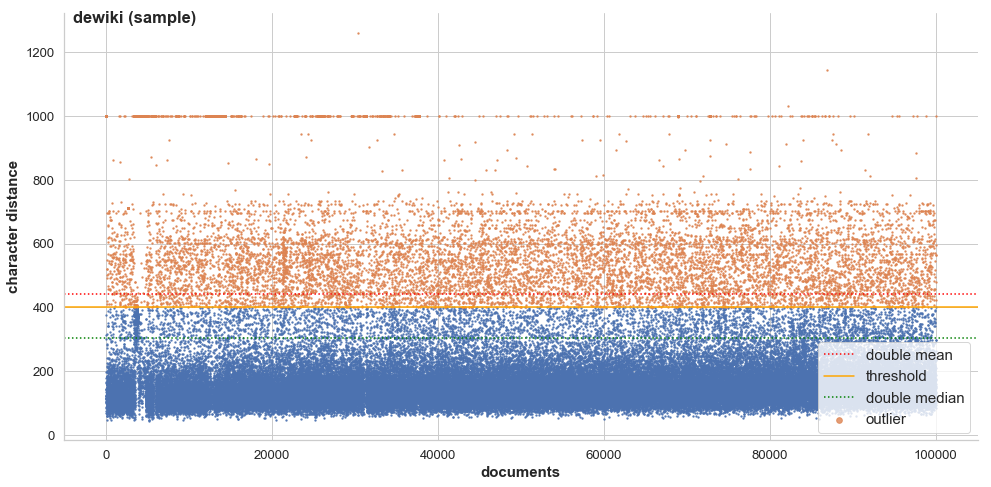

In [10]:
# PLOT

# 400 seems to be a valid limit. We don't loose too many good articles here (~6 %)
threshold = 400
chardist_plot(df.iloc[:100_000], 'dewiki (sample)', threshold=threshold)
outlier1 = df.loc[df.char_dist.between(300, 500), TEXT].tolist()
outlier2 = df.loc[df.char_dist.between(400, 3000), TEXT].tolist()
print(len(outlier1), len(outlier2))
df_new = df[df.char_dist <= threshold]
print(len(df), len(df_new))
df_new = df_new.drop(['char_dist', 'str_len'], axis=1)
#df_new.to_pickle(join(ETL_PATH, 'FOCUS.pickle'))

In [11]:
# comparing with FOCUS score
doc_freq = {'b': 17.0, 'e': 134.0, 'i': 64.0, 'm': 20.0, ' ': 137.0, 'h': 35.0, 'z': 10.0, 'ö': 2.0, 'l': 33.0, '-': 4.0, 'k': 13.0, 'a': 47.0, 'u': 31.0, 'f': 13.0, 's': 53.0, 't': 52.0, 'd': 39.0, 'r': 58.0, 'c': 24.0, 'g': 22.0, 'n': 81.0, 'o': 26.0, '.': 9.0, 'w': 10.0, 'ü': 5.0, 'v': 7.0, ':': 1.0, ',': 6.0, 'p': 11.0, 'ä': 4.0, '8': 0.0, '1': 1.0, '2': 1.0, '0': 1.0, 'j': 1.0, '–': 0.0, 'ß': 1.0, '9': 0.0, '\n': 3.0, 'y': 1.0, '6': 0.0, '5': 0.0, '„': 0.0, '“': 0.0, '?': 0.0, '’': 0.0, '7': 0.0, 'x': 0.0, '(': 0.0, ')': 0.0, '*': 0.0, '3': 0.0, '4': 0.0, 'q': 0.0, '&': 0.0, ';': 0.0, '"': 0.0, '!': 0.0, '@': 0.0, '/': 0.0, "'": 0.0, '+': 0.0, 'é': 0.0}

distance = 0
for k in doc_freq.keys():
    distance += abs(doc_freq[k] - char_freq_train.get(k, 0))
int(distance)

93

In [ ]:
plt.hist(df.char_dist, bins=20)
# multimodal if not restircted to ARTICLEs

In [ ]:
# ignore this cell
good_ids = []
for name in files[:]:
    gc.collect()
    gc.collect()
    corpus = name.split('.')[0]
    print(corpus, end=', ')
    
    f = join(ETL_PATH, corpus + '.pickle')
    df = pd.read_pickle(f)
    df = df[df.subset == 'ARTICLE']
    # Removing 'Begriffsklärung' articles from Wikipedia goodids
    df = df[df.description != 'Begriffsklärung']
    # Removing some artifacts
    df[TEXT] = df.text.str.replace(pat=r'\[\]|\]\]', repl='')
    df = df[df.text != '']
    df['enc_score'] = df[TEXT].apply(encryption_score)
    # keep articles with distance < 400
    good_ids.append(df.loc[df.enc_score < 400, TITLE])

good_ids = pd.concat(good_ids)
good_ids.to_pickle(join(ETL_PATH, 'dewiki_good_ids.pickle'))

### dewac

In [4]:
df = load('dewac')

# SELECT TRAIN SET

df['str_len'] = df[TEXT].str.len()
# for the news datasets we regard only the second half of an article when the paywall sets in
half = df.apply(lambda x: x[TEXT][x['str_len']//2:], axis=1)

Reading 01/32: ../data/preprocessed/dewac_01.pickle
Reading 02/32: ../data/preprocessed/dewac_02.pickle
Reading 03/32: ../data/preprocessed/dewac_03.pickle
Reading 04/32: ../data/preprocessed/dewac_04.pickle
Reading 05/32: ../data/preprocessed/dewac_05.pickle
Reading 06/32: ../data/preprocessed/dewac_06.pickle
Reading 07/32: ../data/preprocessed/dewac_07.pickle
Reading 08/32: ../data/preprocessed/dewac_08.pickle
Reading 09/32: ../data/preprocessed/dewac_09.pickle
Reading 10/32: ../data/preprocessed/dewac_10.pickle
Reading 11/32: ../data/preprocessed/dewac_11.pickle
Reading 12/32: ../data/preprocessed/dewac_12.pickle
Reading 13/32: ../data/preprocessed/dewac_13.pickle
Reading 14/32: ../data/preprocessed/dewac_14.pickle
Reading 15/32: ../data/preprocessed/dewac_15.pickle
Reading 16/32: ../data/preprocessed/dewac_16.pickle
Reading 17/32: ../data/preprocessed/dewac_17.pickle
Reading 18/32: ../data/preprocessed/dewac_18.pickle
Reading 19/32: ../data/preprocessed/dewac_19.pickle
Reading 20/3

In [6]:
# the first 25 articles are ok
train_ids = [
    -8157526149998639139, -8139041734586718076, -6942140900391567610, -8911096388020119024, 6240926672015106313, 1959711681121568241, -5830768473555351539, 9196780305889762322, -1859898204671528775, 4418799350836099921, 4430206916370824726, 7803819644630133892, -4630582756677073888, -8857524272526221661, 9081937174333137614, 1779036211262207863, 6610278774841223644, 2352018544064297518, -2600393555558806245, -6618185189525628783, 5282786949064607814, 6305502385560154586, -6383615109664325842, 4674913760409437023, -5924990954937343321, 5529182561793509790, 2171365852785009044, -8105316796683834251, 5278582610314669683, 3412739076452589341, -2030175838358044016, -2905528300760475504, -5470432379184620388, -1712703150380858845, 4021966044005632984, 1614839259918774512, -3168163503274198537, -1396870867404827402, -9213977513171831737, -3106483392389176943, -475735757977787014, 8971301929692358079, -1910920720034530581, 7753234162230409350, 5081252222671162859, -323430904857398611, -4039058786192050592, -6408002121751832817, -2446825780620187896, 2525263891723167185, -4393357593359329698, 3682519263256631740, 5143163249489432438, -3063009901534308767, -6832731754588576708, 3360322119036446411, -6236944974387299366, 2367568030764218725, 3269026651560289285, -5516482276401386518, -701319585419674793, -4077187576160553816, 793432487150452241, 2128964787793033457, 7620820892600761878, -1560586724301524268, 2729207854213105280, 6937894839248439479, -7357805464550811963, 5588197889886779565, 3785123973583941671, 9077225462057613689, 1343181165327449525, -6284593883905751127, 3081144300272298677, -7048065454179431838, 383063652356625730, 4219249482186769699, 3703743112981590267, -9039103582798352064, -1864532456498160476, -7584204023760646708, 1115726885032468497, 5275192135265340438, -8270582765460223846, -3792788891940835633, -6446086873860395390, 5659502109704324879, 3888149782093904179, -7261300418000484932, 978261807149427025, 2350352831937532537, 6218709643814415497, 7008569376051817727, 2556902394939613955, 3135300437179129631, -7858694700719900761, 2299800294693674634, 7897728987654103080, 7627065054203458020, -6026211578688333218, 1424115435660190128, 5235682836604163022, -8977149940237269711, -7938675784644046330, 7792416117148477438, 2454158391556489734, -2020860044077633676, 812529390795952307, 7875388879706632817, 5333576872339382302, -4407492441188084049, -3425121979472376258, 5696750063784728604, 1714386376976578583, -6356936148687826975, -5331370906422440510, -3511649231679192254, -1123358063636706752, 7025129285763142924, -3041619587739679786, -2364191762995827595, 6825645122042002071, 2220374384088910968, -2551865599176248065, -4543685274221462135, -5665663682085464305, -5533988993205653158, 3864301596154469503, 7767365725999222235, -5183286277530083631, 361201908524874422, 4335777852143195372, 4249125502705091036, 5839763596282060506, 2790741686781312388, -1710611720443385193, -578439611934652698, 5768983400609088839, 1316270655800041615, 8093692536633580355, 126299872829260938, -4038748425019662832, -8279158383736505912, 306029734611823310, -3336289869353029965, -4019506059318225312, 8807638268762030054, 3447474922124298595, 3451644736541610791, -3831480803687571342, 7180313333602556195, 3249107925898164182, 2988881955473471817, -2092475526086179703, -2564360486931999814, -1327459021831730897, -7456683616554566022, -6895634894500609029, 2303838229719251269, 2381087669879164553, -1105250962095620273, 8088059738666067818, -8538237936946159040, -2946383638153347433, -391522753927492767, 6256694672554071082, 4246719605229672979, -9003945106266175277, -8348374377614089726, -6052324372021058580, -5152063258041773886, 4029405673814623311, 7142076085660262924, 9205135720593090168, -598652805432873211, 4698240396985389127, 242674197829635647, 2773669109916237156, 6528368585733762905, 5110762315838036954, -77755173914566589, -3707026730600379077, 716480173289938781, 2967686095334213448, -141418764946644354, -3155362993299370390, 2124880383835925625, 6595537236393356083, -1416548287207976252, 1995727267984666536, -5638574141856664002, 8966964120741465850, 305844453246682603, -2338272415104674985, 6100427635999170459, -854177310619841974, 5037057713781196257, -2333682773826413024, 6882467705001345609, 8089739030001753530, -6138319017899463116, -4687563717453617243, 6534610998108487901, 5251351287214701872, 4131231130244513798, -846355173440908722, -1276296555083020980, 1692798975992096482, 7549612741457812582, 7504037656158960749, 7299329186190764827, -4218806500445076581, -7042056220534620017, 1678695500589367086, 9075941228734172505, -7190616968101947435, -423856135979355642, -1660845024394642209, 6894419878874183117, 3055776774870000378, -4534130652040827997, -59673886137230957, -6772105943891354671, 8432477064871033249, -6857977387969645114, 8424449390382193941, 5863936499626203486, 114933221254588955, -6776603213204002728, -188584209193165013, 4163779740391858141, -8223752029962179985, -2586812367635374125, -7494280998137467721, 8650054382366377629, -4932504245045443256, 2634430804399858989, -275579735077477436, -3055781663998884296, 7787661586023156216, 3453568853761176703, 5625519022919345872, 8036139225114921465, 1884580101143115225, -1484030133562973288, -6696368754211049403, -851653448616309442, 8242416947611399507, -8517350924532703315, -1749137668319664917, 2836206479414615633, -8362509427865885243, -8979946969057455977, 3547785683659679105, -1361138391286112259, -5804539071319914159, 2303348634074300329, -5095419641665836220, 3002240726991489129, 1581066843598558268, -8626886673155085966, 2583506844524399703, -735487286772145217, 1977904686850942639, -8111822706278669762, -5640787800731531619, 542434205550622616, 6366947733206936859, 4591048059723186949, 3421715987820330895, -6513499643449341790, -7624651390916410868, -5911613215962295858, 6592210078946952242, -3623144586309426024, -2142569180374883304, 1444388840627108478, -141622066924503653, -3819135577753178332, 7020517535173017857, 8333238656212282499, 1660466094711966140, 2431818803083778049, 3458878568017322340, -3012488347842301710, -4324877772343473707, -2165938797844277700, -404342069667651514, 7687226567551529606, -4043964500498214044, 1573384450903406428, 2650589899619567845, -1349020487322830808, -3180401657790139913, 5741496210727466883, 810321952417146132, 3988496421355656116, -645465277997795356, -8967301238904723603, 1010728314864055175, -8087398965663321879, 2574816840111181851, 7894807118900540715, -399184000681768792, 7748909073504659179, -7219906383053281256, 378436331808329710, -7788912027601178745, -4951974010405898407, -288455731499192882, -3260452708168311466, 156219657187097107, 6998374124431668526, -6848807968989503069, 8765724359760048303, -9058792593880106368, 6518624135990680685, 3296158687576840901
]
print(len(train_ids))
trainset = df.loc[train_ids, TEXT].tolist()
df.loc[train_ids, TEXT]

319


hash
-8157526149998639139    Moderator Volker Matthies mit Experte PD Dr. A...
-8139041734586718076    Zubereitung Den Lachs antauen laßen, in Würfel...
-6942140900391567610    Wussten Sie, dass die StadtBibliothek Köln die...
-8911096388020119024    29.06.05: Enquete-Kommission fordert Verbesser...
 6240926672015106313    Würzburg (rk/ag) Der Streit zwischen CDU und C...
 1959711681121568241    Ein besonders großes Danke für die Hilfe beim ...
-5830768473555351539    In Niedersachsen gibt es zur Zeit 993.000 Schü...
 9196780305889762322    Was geht uns das an: Christen und Politik Mona...
-1859898204671528775    In seiner literarischen Reportage "Die Hundees...
 4418799350836099921    Was Shakespeare nie zu schreiben wagte Die Fra...
 4430206916370824726    Neuer Chef des Planetariums plant digitale Tec...
 7803819644630133892    Nicht in jedem Fall ist bei ausländischen Küns...
-4630582756677073888    Zukunftsmanifest der IG Metall redet Entsolida...
-8857524272526221661    Protestbr

In [7]:
# GENERATE FOOTPRINT
footprint = footprint_dewa = make_footprint(trainset)
print(footprint)
# compare scores for non-encrypted and encrypted articles
good = df.iloc[-20:][TEXT].tolist()
print('example distances:', [character_distance(string, footprint) for string in good])
#bad = df.loc[7957946436758418097, TEXT]
#print('example for problematic document with distance:', character_distance(bad, footprint))
#print(bad)

# apply metric on corpus
df['char_dist'] = df[TEXT].progress_apply(character_distance, footprint=footprint)

defaultdict(<class 'int'>, {'m': 20.0, 'o': 21.0, 'd': 38.0, 'e': 130.0, 'r': 59.0, 'a': 44.0, 't': 50.0, ' ': 140.0, 'v': 8.0, 'l': 30.0, 'k': 11.0, 'h': 35.0, 'i': 64.0, 's': 52.0, 'x': 0.0, 'p': 7.0, '.': 10.0, 'n': 81.0, 'c': 23.0, 'z': 10.0, 'w': 11.0, 'f': 14.0, ',': 8.0, 'u': 32.0, 'g': 26.0, 'ä': 4.0, ';': 0.0, 'b': 18.0, '-': 3.0, ':': 1.0, 'y': 0.0, '"': 1.0, 'ü': 5.0, '1': 2.0, '3': 1.0, 'ß': 1.0, 'ö': 2.0, '(': 1.0, ')': 1.0, '/': 0.0, '4': 1.0, '2': 2.0, 'j': 1.0, '9': 1.0, '0': 3.0, '?': 0.0, '8': 0.0, '7': 0.0, '!': 0.0, '6': 0.0, '5': 1.0, 'q': 0.0, 'é': 0.0, '\x84': 0.0, '\x93': 0.0, '+': 0.0, "'": 0.0, '%': 0.0, '[': 0.0, ']': 0.0, '&': 0.0, '§': 0.0, '$': 0.0, '»': 0.0, '«': 0.0, 'ë': 0.0, '@': 0.0, '\x96': 0.0, '²': 0.0, 'â': 0.0, '\x80': 0.0, '\x98': 0.0, '^': 0.0, '=': 0.0, '´': 0.0, 'û': 0.0, '`': 0.0, '©': 0.0, '>': 0.0, 'í': 0.0, '*': 0.0, '_': 0.0, '<': 0.0, '#': 0.0, '\x94': 0.0, '|': 0.0, '\x95': 0.0, '°': 0.0, '\x82': 0.0, 'ç': 0.0, 'à': 0.0, '\\': 0.0, 'ô'

double median: 284.0 | double mean: 303.47916
23421 3795
1751871 1727957


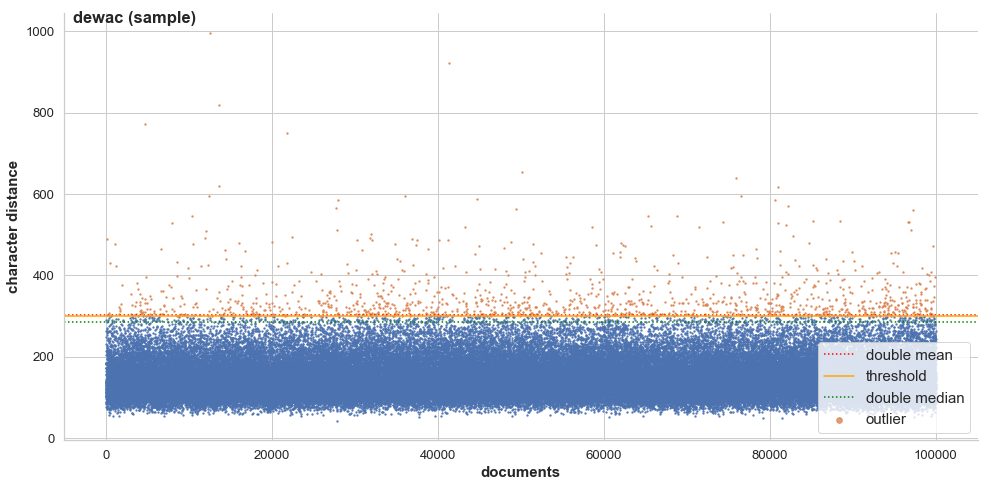

In [10]:
# plot data
threshold = 300
#chardist_plot(df, 'dewac', threshold=threshold)
chardist_plot(df.iloc[:100_000], 'dewac (sample)', threshold=threshold)
# 400 seems to be a valid limit. We don't loose too many good articles here
outlier1 = df.loc[df.char_dist.between(300, 500), TEXT].tolist()
outlier2 = df.loc[df.char_dist.between(400, 3000), TEXT].tolist()
print(len(outlier1), len(outlier2))
df_new = df[df.char_dist <= threshold]
print(len(df), len(df_new))
df_new = df_new.drop(['char_dist', 'str_len'], axis=1)
#df_new.to_pickle(join(ETL_PATH, 'FOCUS.pickle'))

-----

### language identification

In [3]:
# ETL for multilingual Europarl corpus based on the TXT version of the corpus

root = '/home/andreas/workspace/master_cloud/corpora/Europarl/txt'

pattern = re.compile(r'\d+')
slize = None

def handle_chapter(docs, language, file, chapter_id, chapter):
    if chapter is not None:
        cid = int(pattern.search(chapter_id).group(0))
        cstr = '\n'.join(chapter).strip()
        docs.append((language, file, cid, cstr))
    return []

docs = []
for lg in sorted(listdir(root)):
    dpath = join(root, lg)
    for file in islice(sorted(listdir(dpath)), slize):
        name = file.replace('.txt', '')
        fpath = join(dpath, file)
        try:
            with open(fpath, 'r') as fp:
                chapter = None
                c_id = None
                for line in fp.readlines():
                    if line.startswith('<CHAPTER'):
                        chapter, c_id = handle_chapter(docs, lg, name, c_id, chapter), line.strip()
                    elif line.startswith('<SPEAKER'):
                        continue
                    elif line.startswith('<P>'):
                        continue
                    elif line.strip() != '':
                        chapter.append(line.strip())
                chapter = handle_chapter(docs, lg, name, c_id, chapter)
        except UnicodeDecodeError as ude:
            print(ude)
            print(lg, name)

df = (
    pd
    .DataFrame
    .from_records(docs, columns=['language', 'file', 'chapter', 'text'])
    .astype({'language': 'category'})
    .set_index(['language', 'file', 'chapter'])
)
df['length'] = df.text.str.len()
# df.to_pickle(join(ETL_PATH, 'Europarl_multilang.pickle'))
df

'utf-8' codec can't decode byte 0x95 in position 3058: invalid start byte
pl ep-09-10-22-009


text  length
language file               chapter                                                           
bg       ep-07-01-15-003    3                      Състав на Парламента: вж. протоколи      35
         ep-07-01-15-005    5        Одобряване на протокола от предишното заседани...      63
         ep-07-01-15-006    6                      Състав на Парламента: вж. протоколи      35
         ep-07-01-15-007    7                  Проверка на пълномощията: вж. протоколи      39
         ep-07-01-15-010    10                     Внасяне на документи: вж. протоколи      35
         ep-07-01-15-011    11       Въпроси с искане за устен отговор и писмени де...      79
         ep-07-01-15-012    12                                  Петиции: вж. протоколи      22
         ep-07-01-15-013    13       Предаване на текстове на споразумения от Съвет...      62
         ep-07-01-15-014    14       Действия, предприети вследствие резолюции на П...      70
         ep-07-01-15-015    15       Дневен ред на следващото заседание: вж. протоколи      49
         ep-07-01-15-016    16       Закриване на заседанието\n(Se levanta la sesió...      65
         ep-07-01-16-004    4        Избор на заместник-председатели на Европейския...     188
         ep-07-01-16-006    6        Избор на квестори на Европейския парламент (ср...     174
         ep-07-01-16-009    9        Дневен ред на следващото заседание: вж. протоколи      49
         ep-07-01-16-010    10       Закриване на заседанието\n(Die Sitzung wird um...      69
         ep-07-01-17-001    1        Откриване на заседанието\n(Die Sitzung wird um...      65
         ep-07-01-17-002    2                      Внасяне на документи: вж. протоколи      35
         ep-07-01-17-004    4        Одобряване на протокола от предишното заседани...      63
         ep-07-01-17-005    5                      Състав на Парламента: вж. протоколи      35
         ep-07-01-17-010    10       Състав на комисиите (срок за внасяне на предло...     134
         ep-07-01-17-014    14       Дневен ред на следващото заседание: вж. протоколи      49
         ep-07-01-17-015    15       Закриване на заседанието\n(Die Sitzung wird um...      69
         ep-07-01-18-002    2                      Внасяне на документи: вж. протоколи      35
         ep-07-01-18-005    5        Съобщаване на общи позиции на Съвета: вж. прот...     138
         ep-07-01-18-006    6        Одобряване на протокола от предишното заседани...      63
         ep-07-01-18-007    7        Анкетна комисия по кризата в осигурителната ко...     108
         ep-07-01-18-008    8            Съобщение на председателството: вж. протокола      45
         ep-07-01-18-009-01 9                             1. Състав на комисиите (вот)      28
         ep-07-01-18-009-02 9                     2. Препоръка José Ribeiro e Castro (      36
         ep-07-01-18-009-04 9        4. Сертифициране на машинисти, управляващи лок...     107
         ep-07-01-18-009-06 9        6. Приложимо право за извъндоговорните задълже...      66
         ep-07-01-18-009-08 9        8. Седми и Осми годишни доклади на Съвета отно...      72
         ep-07-01-18-011    11        Поправки и намерения за гласуване: вж. протоколи      48
         ep-07-01-18-012    12        Състав на комисиите и делегациите: вж. протоколи      48
         ep-07-01-18-013    13       Искане за снемане на парламентарен имунитет: в...      58
         ep-07-01-18-014    14          Решения относно някои документи: вж. протоколи      46
         ep-07-01-18-015    15       Писмени декларации, вписани в регистъра (член ...      79
         ep-07-01-18-016    16       Предаване на текстове, приети на настоящото за...      68
         ep-07-01-18-017    17           График на следващите заседания: вж. протоколи      45
         ep-07-01-18-018    18       Прекъсване на сесията\nDichiaro interrotta la ...     108
         ep-07-01-31-004    4        Одобряване на протокола от предишното заседани...      

In [11]:
df = pd.read_pickle(join(ETL_PATH, 'Europarl_multilang.pickle'))
df

text  length
language file               chapter                                                           
bg       ep-07-01-15-003    3                      Състав на Парламента: вж. протоколи      35
         ep-07-01-15-005    5        Одобряване на протокола от предишното заседани...      63
         ep-07-01-15-006    6                      Състав на Парламента: вж. протоколи      35
         ep-07-01-15-007    7                  Проверка на пълномощията: вж. протоколи      39
         ep-07-01-15-010    10                     Внасяне на документи: вж. протоколи      35
         ep-07-01-15-011    11       Въпроси с искане за устен отговор и писмени де...      79
         ep-07-01-15-012    12                                  Петиции: вж. протоколи      22
         ep-07-01-15-013    13       Предаване на текстове на споразумения от Съвет...      62
         ep-07-01-15-014    14       Действия, предприети вследствие резолюции на П...      70
         ep-07-01-15-015    15       Дневен ред на следващото заседание: вж. протоколи      49
         ep-07-01-15-016    16       Закриване на заседанието\n(Se levanta la sesió...      65
         ep-07-01-16-004    4        Избор на заместник-председатели на Европейския...     188
         ep-07-01-16-006    6        Избор на квестори на Европейския парламент (ср...     174
         ep-07-01-16-009    9        Дневен ред на следващото заседание: вж. протоколи      49
         ep-07-01-16-010    10       Закриване на заседанието\n(Die Sitzung wird um...      69
         ep-07-01-17-001    1        Откриване на заседанието\n(Die Sitzung wird um...      65
         ep-07-01-17-002    2                      Внасяне на документи: вж. протоколи      35
         ep-07-01-17-004    4        Одобряване на протокола от предишното заседани...      63
         ep-07-01-17-005    5                      Състав на Парламента: вж. протоколи      35
         ep-07-01-17-010    10       Състав на комисиите (срок за внасяне на предло...     134
         ep-07-01-17-014    14       Дневен ред на следващото заседание: вж. протоколи      49
         ep-07-01-17-015    15       Закриване на заседанието\n(Die Sitzung wird um...      69
         ep-07-01-18-002    2                      Внасяне на документи: вж. протоколи      35
         ep-07-01-18-005    5        Съобщаване на общи позиции на Съвета: вж. прот...     138
         ep-07-01-18-006    6        Одобряване на протокола от предишното заседани...      63
         ep-07-01-18-007    7        Анкетна комисия по кризата в осигурителната ко...     108
         ep-07-01-18-008    8            Съобщение на председателството: вж. протокола      45
         ep-07-01-18-009-01 9                             1. Състав на комисиите (вот)      28
         ep-07-01-18-009-02 9                     2. Препоръка José Ribeiro e Castro (      36
         ep-07-01-18-009-04 9        4. Сертифициране на машинисти, управляващи лок...     107
         ep-07-01-18-009-06 9        6. Приложимо право за извъндоговорните задълже...      66
         ep-07-01-18-009-08 9        8. Седми и Осми годишни доклади на Съвета отно...      72
         ep-07-01-18-011    11        Поправки и намерения за гласуване: вж. протоколи      48
         ep-07-01-18-012    12        Състав на комисиите и делегациите: вж. протоколи      48
         ep-07-01-18-013    13       Искане за снемане на парламентарен имунитет: в...      58
         ep-07-01-18-014    14          Решения относно някои документи: вж. протоколи      46
         ep-07-01-18-015    15       Писмени декларации, вписани в регистъра (член ...      79
         ep-07-01-18-016    16       Предаване на текстове, приети на настоящото за...      68
         ep-07-01-18-017    17           График на следващите заседания: вж. протоколи      45
         ep-07-01-18-018    18       Прекъсване на сесията\nDichiaro interrotta la ...     108
         ep-07-01-31-004    4        Одобряване на протокола от предишното заседани...      

In [ ]:
def predict(document, length_threshold=0):
    if length_threshold > 0:
        if document.length < length_threshold:
            return None

    true = document.name[0]
    distances = []
    for lang, footprint in footprints.items():
        distance = character_distance(string=document.text, footprint=footprint)
        distances.append((distance, lang))
    sorted_distances = sorted(distances)
    prediction = sorted_distances[0][1]
    return prediction

In [ ]:
# split dataset (small train set)
train_size_per_lang = 25
min_doc_length_for_training = 1000
dfx = df[df.length > min_doc_length_for_training].groupby('language').head(train_size_per_lang)

df['train'] = False
df.loc[dfx.index, 'train'] = True
df_train = df[df.train]
df_test = df[~df.train]

# train (generate footprints per language)
footprints = dict()
for lang in df_train.index.levels[0]:
    lang_trainset = df_train.query('language == @lang')[TEXT].tolist()
    footprints[lang] = make_footprint(lang_trainset)

In [47]:
# predict
df_test['pred'] = df_test.progress_apply(predict, axis=1)
df_test['true'] = df_test.index.get_level_values('language')
df_test['correct'] = df_test.pred == df_test.true
print('Accuracy:', df_test.correct.sum() / len(df_test)) # 

Accuracy: 0.6902674978722266


In [52]:
# predict (omitting short test documents)
df_test['pred'] = df_test.progress_apply(predict, length_threshold=100, axis=1)
df_test = df_test.dropna()
df_test['true'] = df_test.index.get_level_values('language')
df_test['correct'] = df_test.pred == df_test.true
print('Accuracy:', df_test.correct.sum() / len(df_test)) # 

Accuracy: 0.9071081196747461


In [53]:
# split dataset (large train set)
train_size_per_lang = 1000
min_doc_length_for_training = 1000
dfx = df[df.length > min_doc_length_for_training].groupby('language').head(train_size_per_lang)

df['train'] = False
df.loc[dfx.index, 'train'] = True
df_train = df[df.train]
df_test = df[~df.train]

# train (generate footprints per language)
footprints = dict()
for lang in df_train.index.levels[0]:
    lang_trainset = df_train.query('language == @lang')[TEXT].tolist()
    footprints[lang] = make_footprint(lang_trainset)

bg
cs
da
de
el
en
es
et
fi
fr
hu
it
lt
lv
nl
pl
pt
ro
sk
sl
sv


In [54]:
# predict
df_test['pred'] = df_test.progress_apply(predict, axis=1)
df_test['true'] = df_test.index.get_level_values('language')
df_test['correct'] = df_test.pred == df_test.true
print('Accuracy:', df_test.correct.sum() / len(df_test)) # 

Accuracy: 0.6584403102903824


In [55]:
# predict (omitting short test documents)
df_test['pred'] = df_test.progress_apply(predict, length_threshold=100, axis=1)
df_test = df_test.dropna()
df_test['true'] = df_test.index.get_level_values('language')
df_test['correct'] = df_test.pred == df_test.true
print('Accuracy:', df_test.correct.sum() / len(df_test)) # 

Accuracy: 0.8889948167345427
